# Deep Q-Learning Algorithm 

Simple Q-learning is basic and is all about learning state action value for all possible 

### Algorithm 
![alt text](sampling-training.jpg)

In [19]:
import gym
import random
import numpy as np
from collections import deque
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch.nn.init as init
import os

In [20]:
class DQN(nn.Module):
    def __init__(self, hidden_units, state_size, action_size):
        super(DQN, self).__init__()
        self.hidden_units = hidden_units
        self.input_dim = state_size
        self.output_dim = action_size

        self.q_netwrok = nn.Sequential(
            nn.Linear(self.input_dim, hidden_units),
            nn.LeakyReLU(),
            nn.Linear(hidden_units, hidden_units),
            nn.LeakyReLU(),
            nn.Linear(hidden_units, self.hidden_units),
            nn.LeakyReLU(inplace=True),
            nn.Linear(self.hidden_units, self.output_dim)  # Final layer to output Q-values
        )
        # self.q_netwrok.apply(self.initialize_weights)
    
    def forward(self, x):
        if not isinstance(x, torch.Tensor):
            x = torch.tensor(x, dtype=torch.float32)
        return self.q_netwrok(x)
    

def initialize_weights(module):
    if isinstance(module, nn.Linear):
        init.xavier_uniform_(module.weight)
    elif isinstance(module, nn.Conv2d):
        init.kaiming_normal_(module.weight, mode='fan_in', nonlinearity='relu')



In [30]:
# env = gym.make("CartPole-v1", new_step_api=True)
import gymnasium as gym
env = gym.make('Walker2d-v5')
state_size = env.observation_space.shape[0]

num_joints = 6
base_actions = np.eye(num_joints)  # Identity matrix for single joint activation
# Create a list of 13 actions: no-op, positive torque on each joint, negative torque on each joint
discrete_actions = (
    [[0.0] * num_joints] +  # No action
    base_actions.tolist() +
    (-base_actions).tolist()
)
action_size = len(discrete_actions)

# action_size = env.action_space
# action_size = 6
# Hyperparameters
gamma = 0.99
epsilon = 1.0
epsilon_min = 0.01
epsilon_decay = 0.9995
learning_rate = 3e-4
batch_size = 128
memory_size = 100000
learning_starts = 5000
train_frequency = 4
tau = 0.005
episodes = 10000
max_steps_per_episode = 1000

In [22]:
memory = deque(maxlen=memory_size)

In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
print(f"State size: {state_size}")
print(f"Discretized action size: {action_size}")

target_network = DQN(256, state_size=state_size, action_size=action_size).to(device)
# initialize_weights(target_network.q_netwrok)
q_network = DQN(256, state_size=state_size, action_size=action_size).to(device)
# initialize_weights(q_network.q_netwrok)
target_network.load_state_dict(q_network.state_dict())
print("No. of trainable parameters:", sum(p.numel() for p in q_network.parameters() if p.requires_grad))

target_network.eval()
optimizer = optim.Adam(q_network.parameters(), lr=learning_rate)
loss_fn = nn.MSELoss()

Using device: cuda
State size: 17
Discretized action size: 13
No. of trainable parameters: 139533


In [24]:
def epsilon_greedy_action(state, epsilon=epsilon):
    if random.random() < epsilon:
        return random.choice(range(action_size))
    else:
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        with torch.no_grad():
            q_values = q_network(state)
            
        return q_values.argmax().item()

In [25]:
def replay():
    if len(memory) < batch_size:
        return 
    
    minibatch = random.sample(memory, batch_size)

    current_states, actions, rewards, next_states, dones = zip(*minibatch)
    # current_states, actions, rewards, next_states, dones = np.ndarray(current_states), np.ndarray(actions), np.ndarray(rewards), np.ndarray(next_states), np.ndarray(dones) 
    
    current_states = torch.FloatTensor(np.array(current_states)).to(device=device)
    actions = torch.LongTensor(np.array(actions)).unsqueeze(1).to(device)
    rewards = torch.FloatTensor(np.array(rewards)).unsqueeze(1).to(device)
    next_states = torch.FloatTensor(np.array(next_states)).to(device)
    dones = torch.FloatTensor(np.array(dones)).unsqueeze(1).to(device)

    current_q = q_network(current_states).gather(1, actions)

    pred_q = target_network(next_states).max(1)[0].detach().unsqueeze(1)
    target_q = rewards + (gamma * pred_q * (1 - dones))

    loss = loss_fn(current_q, target_q) # current_q --> [64, 2]    target_q = [64, 1]   # fixed 

    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(q_network.parameters(), 1.0)
    optimizer.step()
    return loss.item()


In [26]:
def soft_update_target_network():
    """Soft update model parameters. θ_target = τ*θ_local + (1 - τ)*θ_target"""
    for target_param, local_param in zip(target_network.parameters(), q_network.parameters()):
        target_param.data.copy_(tau * local_param.data + (1.0 - tau) * target_param.data)

In [31]:
all_rewards = []
avg_rewards = []
total_timesteps = 0
best_avg_reward = -np.inf
save_dir = "dqn_walker_models"
os.makedirs(save_dir, exist_ok=True)

for episode in tqdm(range(episodes)):
    state, _ = env.reset()
    episode_reward = 0
    
    for t in range(max_steps_per_episode):
        total_timesteps += 1
        
        action_index = epsilon_greedy_action(state, epsilon)
        continuous_action = discrete_actions[action_index]
        
        next_state, reward, terminated, truncated, _ = env.step(continuous_action)
        done = terminated or truncated
        
        memory.append((state, action_index, reward, next_state, done))
        
        state = next_state
        episode_reward += reward

        if total_timesteps > learning_starts and total_timesteps % train_frequency == 0:
            replay()
            soft_update_target_network()

        if done:
            break
            
    epsilon = max(epsilon_min, epsilon * epsilon_decay)

    all_rewards.append(episode_reward)
    avg_reward = np.mean(all_rewards[-100:])
    avg_rewards.append(avg_reward)

    if episode % 500 == 0:
        print(f"\nEpisode {episode} | Total Reward: {episode_reward:.2f} | Avg Reward (Last 100): {avg_reward:.2f} | Epsilon: {epsilon:.4f} | Timesteps: {total_timesteps}")

    # Checkpointing: Save the best model and periodic checkpoints
    if avg_reward > best_avg_reward:
        best_avg_reward = avg_reward
        torch.save(q_network.state_dict(), os.path.join(save_dir, "best_model.pth"))
        print(f"** New best model saved with avg reward: {best_avg_reward:.2f} **")

    if episode % 1000 == 0 and episode > 0:
        torch.save(q_network.state_dict(), os.path.join(save_dir, f"checkpoint_episode_{episode}.pth"))
        print(f"++ Checkpoint saved at episode {episode} ++")


  0%|          | 13/10000 [00:00<01:20, 123.81it/s]


Episode 0 | Total Reward: 5.14 | Avg Reward (Last 100): 5.14 | Epsilon: 0.9995 | Timesteps: 22
** New best model saved with avg reward: 5.14 **
** New best model saved with avg reward: 6.13 **
** New best model saved with avg reward: 6.47 **
** New best model saved with avg reward: 8.82 **


  5%|▍         | 468/10000 [00:16<09:24, 16.90it/s] 

** New best model saved with avg reward: 8.83 **
** New best model saved with avg reward: 8.92 **


  5%|▌         | 503/10000 [00:18<08:32, 18.53it/s]


Episode 500 | Total Reward: 8.35 | Avg Reward (Last 100): 8.73 | Epsilon: 0.7784 | Timesteps: 13016
** New best model saved with avg reward: 8.95 **


  5%|▌         | 509/10000 [00:18<08:47, 17.98it/s]

** New best model saved with avg reward: 8.97 **
** New best model saved with avg reward: 9.00 **
** New best model saved with avg reward: 9.11 **


  5%|▌         | 511/10000 [00:19<09:59, 15.84it/s]

** New best model saved with avg reward: 9.23 **
** New best model saved with avg reward: 9.30 **


  5%|▌         | 517/10000 [00:19<09:16, 17.04it/s]

** New best model saved with avg reward: 9.42 **


  5%|▌         | 549/10000 [00:21<09:08, 17.24it/s]

** New best model saved with avg reward: 9.54 **
** New best model saved with avg reward: 9.58 **
** New best model saved with avg reward: 9.61 **
** New best model saved with avg reward: 9.64 **


  6%|▌         | 553/10000 [00:21<10:47, 14.59it/s]

** New best model saved with avg reward: 9.83 **
** New best model saved with avg reward: 9.88 **


 10%|▉         | 972/10000 [00:46<11:31, 13.06it/s]

** New best model saved with avg reward: 10.03 **


 10%|▉         | 987/10000 [00:47<10:02, 14.97it/s]

** New best model saved with avg reward: 10.05 **
** New best model saved with avg reward: 10.19 **
** New best model saved with avg reward: 10.24 **


 10%|▉         | 989/10000 [00:47<10:53, 13.80it/s]

** New best model saved with avg reward: 10.24 **


 10%|▉         | 994/10000 [00:48<12:40, 11.85it/s]

** New best model saved with avg reward: 11.87 **


 10%|▉         | 996/10000 [00:48<12:27, 12.04it/s]

** New best model saved with avg reward: 12.03 **
** New best model saved with avg reward: 12.11 **
** New best model saved with avg reward: 12.11 **


 10%|█         | 1003/10000 [00:48<09:51, 15.21it/s]


Episode 1000 | Total Reward: 7.10 | Avg Reward (Last 100): 11.79 | Epsilon: 0.6062 | Timesteps: 26244
++ Checkpoint saved at episode 1000 ++


 10%|█         | 1008/10000 [00:49<11:57, 12.53it/s]

** New best model saved with avg reward: 12.66 **


 14%|█▎        | 1365/10000 [01:11<11:38, 12.36it/s]

** New best model saved with avg reward: 12.79 **


 14%|█▍        | 1376/10000 [01:12<10:58, 13.10it/s]

** New best model saved with avg reward: 13.65 **


 14%|█▍        | 1381/10000 [01:12<10:53, 13.19it/s]

** New best model saved with avg reward: 13.89 **
** New best model saved with avg reward: 14.22 **


 15%|█▌        | 1502/10000 [01:21<09:15, 15.31it/s]


Episode 1500 | Total Reward: 3.67 | Avg Reward (Last 100): 13.28 | Epsilon: 0.4720 | Timesteps: 39921


 15%|█▌        | 1507/10000 [01:21<11:56, 11.85it/s]

** New best model saved with avg reward: 17.17 **


 17%|█▋        | 1657/10000 [01:33<18:01,  7.72it/s]

** New best model saved with avg reward: 17.39 **


 17%|█▋        | 1661/10000 [01:33<15:41,  8.86it/s]

** New best model saved with avg reward: 19.10 **


 17%|█▋        | 1673/10000 [01:34<14:56,  9.29it/s]

** New best model saved with avg reward: 20.39 **
** New best model saved with avg reward: 20.57 **


 17%|█▋        | 1677/10000 [01:35<13:10, 10.53it/s]

** New best model saved with avg reward: 20.71 **
** New best model saved with avg reward: 20.76 **
** New best model saved with avg reward: 20.83 **


 17%|█▋        | 1679/10000 [01:35<14:14,  9.74it/s]

** New best model saved with avg reward: 20.96 **
** New best model saved with avg reward: 21.00 **
** New best model saved with avg reward: 21.03 **


 17%|█▋        | 1682/10000 [01:35<12:35, 11.01it/s]

** New best model saved with avg reward: 21.29 **


 17%|█▋        | 1687/10000 [01:36<14:19,  9.67it/s]

** New best model saved with avg reward: 24.87 **
** New best model saved with avg reward: 24.91 **
** New best model saved with avg reward: 24.96 **


 17%|█▋        | 1690/10000 [01:36<12:28, 11.10it/s]

** New best model saved with avg reward: 25.00 **
** New best model saved with avg reward: 25.13 **
** New best model saved with avg reward: 25.15 **


 17%|█▋        | 1694/10000 [01:36<14:59,  9.23it/s]

** New best model saved with avg reward: 28.25 **
** New best model saved with avg reward: 28.29 **


 17%|█▋        | 1698/10000 [01:37<12:27, 11.10it/s]

** New best model saved with avg reward: 28.42 **
** New best model saved with avg reward: 28.44 **


 17%|█▋        | 1705/10000 [01:37<10:46, 12.83it/s]

** New best model saved with avg reward: 28.50 **
** New best model saved with avg reward: 28.57 **


 17%|█▋        | 1709/10000 [01:38<12:08, 11.38it/s]

** New best model saved with avg reward: 29.22 **


 20%|██        | 2002/10000 [02:02<10:56, 12.17it/s]


Episode 2000 | Total Reward: 3.12 | Avg Reward (Last 100): 16.99 | Epsilon: 0.3676 | Timesteps: 55685
++ Checkpoint saved at episode 2000 ++


 22%|██▏       | 2172/10000 [02:18<16:20,  7.98it/s]

** New best model saved with avg reward: 31.15 **
** New best model saved with avg reward: 31.25 **
** New best model saved with avg reward: 31.33 **


 22%|██▏       | 2234/10000 [02:25<11:33, 11.20it/s]

** New best model saved with avg reward: 31.49 **


 22%|██▏       | 2236/10000 [02:25<16:52,  7.67it/s]

** New best model saved with avg reward: 33.77 **


 22%|██▏       | 2240/10000 [02:25<13:51,  9.33it/s]

** New best model saved with avg reward: 34.21 **


 22%|██▏       | 2247/10000 [02:26<14:37,  8.83it/s]

** New best model saved with avg reward: 35.14 **
** New best model saved with avg reward: 35.18 **


 23%|██▎       | 2258/10000 [02:27<07:29, 17.20it/s]

** New best model saved with avg reward: 38.58 **


 23%|██▎       | 2261/10000 [02:28<18:03,  7.14it/s]

** New best model saved with avg reward: 38.81 **
** New best model saved with avg reward: 38.83 **


 23%|██▎       | 2266/10000 [02:28<16:30,  7.81it/s]

** New best model saved with avg reward: 40.49 **


 23%|██▎       | 2288/10000 [02:30<16:01,  8.02it/s]

** New best model saved with avg reward: 40.61 **


 23%|██▎       | 2290/10000 [02:31<20:57,  6.13it/s]

** New best model saved with avg reward: 42.49 **
** New best model saved with avg reward: 42.61 **


 23%|██▎       | 2297/10000 [02:31<13:15,  9.68it/s]

** New best model saved with avg reward: 42.63 **
** New best model saved with avg reward: 42.75 **


 23%|██▎       | 2307/10000 [02:32<11:48, 10.86it/s]

** New best model saved with avg reward: 44.90 **


 23%|██▎       | 2309/10000 [02:32<12:36, 10.17it/s]

** New best model saved with avg reward: 45.02 **
** New best model saved with avg reward: 45.27 **


 24%|██▍       | 2428/10000 [02:47<28:35,  4.41it/s]

** New best model saved with avg reward: 45.77 **
** New best model saved with avg reward: 46.34 **


 24%|██▍       | 2429/10000 [02:47<26:14,  4.81it/s]

** New best model saved with avg reward: 46.75 **
** New best model saved with avg reward: 46.83 **


 24%|██▍       | 2431/10000 [02:48<31:36,  3.99it/s]

** New best model saved with avg reward: 51.02 **


 24%|██▍       | 2433/10000 [02:48<36:05,  3.49it/s]

** New best model saved with avg reward: 55.79 **
** New best model saved with avg reward: 56.13 **


 24%|██▍       | 2440/10000 [02:49<17:19,  7.27it/s]

** New best model saved with avg reward: 56.31 **


 24%|██▍       | 2443/10000 [02:49<17:12,  7.32it/s]

** New best model saved with avg reward: 57.03 **
** New best model saved with avg reward: 57.26 **


 24%|██▍       | 2445/10000 [02:50<19:42,  6.39it/s]

** New best model saved with avg reward: 57.60 **
** New best model saved with avg reward: 57.64 **


 24%|██▍       | 2447/10000 [02:51<34:21,  3.66it/s]

** New best model saved with avg reward: 63.88 **


 25%|██▍       | 2452/10000 [02:51<20:26,  6.16it/s]

** New best model saved with avg reward: 64.84 **


 25%|██▍       | 2456/10000 [02:52<24:10,  5.20it/s]

** New best model saved with avg reward: 65.20 **
** New best model saved with avg reward: 65.52 **


 25%|██▍       | 2475/10000 [02:54<15:25,  8.13it/s]

** New best model saved with avg reward: 66.90 **


 25%|██▍       | 2489/10000 [02:56<23:56,  5.23it/s]

** New best model saved with avg reward: 67.09 **
** New best model saved with avg reward: 67.41 **


 25%|██▍       | 2492/10000 [02:56<20:03,  6.24it/s]

** New best model saved with avg reward: 67.80 **
** New best model saved with avg reward: 67.96 **
** New best model saved with avg reward: 68.16 **


 25%|██▍       | 2495/10000 [02:57<17:20,  7.21it/s]

** New best model saved with avg reward: 68.17 **
** New best model saved with avg reward: 68.29 **


 25%|██▍       | 2498/10000 [02:57<19:59,  6.25it/s]

** New best model saved with avg reward: 69.37 **
** New best model saved with avg reward: 69.47 **


 25%|██▌       | 2503/10000 [02:58<12:35,  9.92it/s]


Episode 2500 | Total Reward: -2.22 | Avg Reward (Last 100): 67.28 | Epsilon: 0.2863 | Timesteps: 76763


 29%|██▉       | 2916/10000 [03:56<24:27,  4.83it/s]

** New best model saved with avg reward: 69.71 **


 30%|██▉       | 2980/10000 [04:07<24:25,  4.79it/s]

** New best model saved with avg reward: 69.90 **
** New best model saved with avg reward: 70.09 **


 30%|██▉       | 2999/10000 [04:09<16:23,  7.12it/s]

** New best model saved with avg reward: 73.64 **
** New best model saved with avg reward: 73.71 **
** New best model saved with avg reward: 77.84 **


 30%|███       | 3001/10000 [04:10<30:10,  3.87it/s]


Episode 3000 | Total Reward: 368.95 | Avg Reward (Last 100): 81.43 | Epsilon: 0.2229 | Timesteps: 102370
** New best model saved with avg reward: 81.43 **
++ Checkpoint saved at episode 3000 ++


 30%|███       | 3004/10000 [04:11<23:05,  5.05it/s]

** New best model saved with avg reward: 81.72 **


 30%|███       | 3006/10000 [04:11<30:16,  3.85it/s]

** New best model saved with avg reward: 82.05 **


 30%|███       | 3009/10000 [04:12<23:22,  4.98it/s]

** New best model saved with avg reward: 83.58 **


 30%|███       | 3034/10000 [04:16<23:00,  5.05it/s]

** New best model saved with avg reward: 84.31 **


 30%|███       | 3040/10000 [04:18<31:54,  3.64it/s]

** New best model saved with avg reward: 85.93 **


 31%|███       | 3116/10000 [04:31<37:45,  3.04it/s]

** New best model saved with avg reward: 85.96 **


 32%|███▏      | 3240/10000 [04:55<37:17,  3.02it/s]

** New best model saved with avg reward: 86.71 **


 32%|███▏      | 3243/10000 [04:56<28:41,  3.93it/s]

** New best model saved with avg reward: 90.81 **


 32%|███▎      | 3250/10000 [04:57<20:38,  5.45it/s]

** New best model saved with avg reward: 91.17 **


 33%|███▎      | 3252/10000 [04:57<31:52,  3.53it/s]

** New best model saved with avg reward: 95.28 **
** New best model saved with avg reward: 95.31 **


 33%|███▎      | 3263/10000 [04:59<17:51,  6.29it/s]

** New best model saved with avg reward: 96.24 **
** New best model saved with avg reward: 96.50 **


 33%|███▎      | 3264/10000 [04:59<17:02,  6.59it/s]

** New best model saved with avg reward: 96.82 **


 33%|███▎      | 3266/10000 [05:00<29:52,  3.76it/s]

** New best model saved with avg reward: 102.10 **
** New best model saved with avg reward: 102.25 **


 33%|███▎      | 3267/10000 [05:01<38:29,  2.91it/s]

** New best model saved with avg reward: 106.95 **


 33%|███▎      | 3268/10000 [05:02<48:37,  2.31it/s]

** New best model saved with avg reward: 111.30 **


 35%|███▌      | 3500/10000 [05:50<19:44,  5.49it/s]


Episode 3500 | Total Reward: 4.10 | Avg Reward (Last 100): 108.69 | Epsilon: 0.1736 | Timesteps: 137274


 35%|███▌      | 3502/10000 [05:50<23:53,  4.53it/s]

** New best model saved with avg reward: 112.18 **


 35%|███▌      | 3503/10000 [05:50<23:48,  4.55it/s]

** New best model saved with avg reward: 112.60 **
** New best model saved with avg reward: 112.76 **


 35%|███▌      | 3505/10000 [05:51<20:16,  5.34it/s]

** New best model saved with avg reward: 113.27 **


 35%|███▌      | 3507/10000 [05:51<22:23,  4.83it/s]

** New best model saved with avg reward: 116.53 **


 35%|███▌      | 3509/10000 [05:52<25:16,  4.28it/s]

** New best model saved with avg reward: 117.70 **
** New best model saved with avg reward: 118.05 **


 35%|███▌      | 3511/10000 [05:52<23:38,  4.58it/s]

** New best model saved with avg reward: 119.71 **


 35%|███▌      | 3512/10000 [05:52<27:53,  3.88it/s]

** New best model saved with avg reward: 121.08 **


 35%|███▌      | 3513/10000 [05:53<33:38,  3.21it/s]

** New best model saved with avg reward: 122.83 **


 35%|███▌      | 3514/10000 [05:53<31:48,  3.40it/s]

** New best model saved with avg reward: 123.22 **


 35%|███▌      | 3516/10000 [05:54<33:04,  3.27it/s]

** New best model saved with avg reward: 127.09 **


 35%|███▌      | 3518/10000 [05:54<28:36,  3.78it/s]

** New best model saved with avg reward: 129.83 **


 35%|███▌      | 3520/10000 [05:55<31:04,  3.47it/s]

** New best model saved with avg reward: 134.40 **
** New best model saved with avg reward: 134.42 **


 35%|███▌      | 3527/10000 [05:57<40:45,  2.65it/s]

** New best model saved with avg reward: 135.91 **


 35%|███▌      | 3529/10000 [05:58<37:09,  2.90it/s]

** New best model saved with avg reward: 139.16 **


 35%|███▌      | 3534/10000 [05:59<27:51,  3.87it/s]

** New best model saved with avg reward: 139.88 **
** New best model saved with avg reward: 140.25 **


 35%|███▌      | 3538/10000 [06:01<1:00:14,  1.79it/s]

** New best model saved with avg reward: 141.64 **


 35%|███▌      | 3539/10000 [06:02<1:03:07,  1.71it/s]

** New best model saved with avg reward: 145.76 **


 35%|███▌      | 3540/10000 [06:02<59:02,  1.82it/s]  

** New best model saved with avg reward: 148.69 **


 35%|███▌      | 3541/10000 [06:03<57:46,  1.86it/s]

** New best model saved with avg reward: 150.52 **


 35%|███▌      | 3543/10000 [06:04<49:57,  2.15it/s]  

** New best model saved with avg reward: 155.30 **


 35%|███▌      | 3544/10000 [06:04<51:41,  2.08it/s]

** New best model saved with avg reward: 158.35 **


 35%|███▌      | 3549/10000 [06:05<29:54,  3.60it/s]

** New best model saved with avg reward: 162.61 **


 36%|███▌      | 3560/10000 [06:08<29:47,  3.60it/s]

** New best model saved with avg reward: 163.36 **


 36%|███▌      | 3565/10000 [06:11<52:43,  2.03it/s]

** New best model saved with avg reward: 169.74 **


 36%|███▌      | 3570/10000 [06:12<33:25,  3.21it/s]

** New best model saved with avg reward: 174.97 **
** New best model saved with avg reward: 174.99 **


 36%|███▌      | 3574/10000 [06:15<59:58,  1.79it/s]

** New best model saved with avg reward: 179.82 **


 36%|███▌      | 3575/10000 [06:15<56:35,  1.89it/s]

** New best model saved with avg reward: 182.78 **
** New best model saved with avg reward: 182.90 **


 36%|███▌      | 3577/10000 [06:15<41:30,  2.58it/s]

** New best model saved with avg reward: 182.91 **


 36%|███▌      | 3578/10000 [06:16<45:04,  2.37it/s]

** New best model saved with avg reward: 186.12 **


 36%|███▌      | 3580/10000 [06:17<37:15,  2.87it/s]

** New best model saved with avg reward: 186.68 **


 36%|███▌      | 3582/10000 [06:18<47:26,  2.25it/s]

** New best model saved with avg reward: 187.82 **


 36%|███▌      | 3583/10000 [06:18<52:29,  2.04it/s]

** New best model saved with avg reward: 190.78 **


 36%|███▌      | 3584/10000 [06:19<1:01:06,  1.75it/s]

** New best model saved with avg reward: 192.74 **


 36%|███▌      | 3585/10000 [06:20<59:27,  1.80it/s]  

** New best model saved with avg reward: 196.23 **


 36%|███▌      | 3586/10000 [06:20<1:07:18,  1.59it/s]

** New best model saved with avg reward: 198.06 **


 36%|███▌      | 3587/10000 [06:21<56:21,  1.90it/s]  

** New best model saved with avg reward: 198.65 **


 36%|███▌      | 3588/10000 [06:21<50:48,  2.10it/s]

** New best model saved with avg reward: 201.29 **


 36%|███▌      | 3591/10000 [06:22<47:52,  2.23it/s]

** New best model saved with avg reward: 205.32 **


 36%|███▌      | 3597/10000 [06:24<40:37,  2.63it/s]

** New best model saved with avg reward: 206.05 **


 36%|███▌      | 3599/10000 [06:25<34:50,  3.06it/s]

** New best model saved with avg reward: 206.46 **


 36%|███▌      | 3600/10000 [06:26<47:56,  2.23it/s]

** New best model saved with avg reward: 211.93 **


 36%|███▌      | 3601/10000 [06:26<47:51,  2.23it/s]

** New best model saved with avg reward: 215.58 **


 36%|███▌      | 3603/10000 [06:27<45:41,  2.33it/s]

** New best model saved with avg reward: 216.16 **


 36%|███▌      | 3605/10000 [06:27<32:09,  3.31it/s]

** New best model saved with avg reward: 216.48 **
** New best model saved with avg reward: 216.49 **


 36%|███▌      | 3607/10000 [06:28<34:51,  3.06it/s]

** New best model saved with avg reward: 217.94 **


 36%|███▌      | 3609/10000 [06:28<33:06,  3.22it/s]

** New best model saved with avg reward: 218.81 **


 36%|███▌      | 3610/10000 [06:29<44:24,  2.40it/s]

** New best model saved with avg reward: 223.73 **


 40%|████      | 4001/10000 [08:18<17:09,  5.83it/s]  


Episode 4000 | Total Reward: 37.72 | Avg Reward (Last 100): 106.90 | Epsilon: 0.1352 | Timesteps: 188066
++ Checkpoint saved at episode 4000 ++


 45%|████▌     | 4502/10000 [10:46<18:05,  5.07it/s]  


Episode 4500 | Total Reward: 11.16 | Avg Reward (Last 100): 135.93 | Epsilon: 0.1053 | Timesteps: 238693


 46%|████▌     | 4606/10000 [11:22<49:36,  1.81it/s]

** New best model saved with avg reward: 226.70 **


 46%|████▌     | 4607/10000 [11:23<53:22,  1.68it/s]

** New best model saved with avg reward: 232.85 **


 46%|████▌     | 4609/10000 [11:23<36:55,  2.43it/s]

** New best model saved with avg reward: 233.24 **
** New best model saved with avg reward: 234.04 **


 46%|████▌     | 4611/10000 [11:26<1:42:28,  1.14s/it]

** New best model saved with avg reward: 242.27 **


 46%|████▌     | 4612/10000 [11:27<1:39:10,  1.10s/it]

** New best model saved with avg reward: 247.11 **


 46%|████▌     | 4613/10000 [11:28<1:23:30,  1.08it/s]

** New best model saved with avg reward: 250.13 **


 46%|████▌     | 4615/10000 [11:29<59:16,  1.51it/s]  

** New best model saved with avg reward: 255.23 **


 46%|████▌     | 4616/10000 [11:30<1:22:05,  1.09it/s]

** New best model saved with avg reward: 260.37 **


 46%|████▌     | 4619/10000 [11:31<40:37,  2.21it/s]  

** New best model saved with avg reward: 262.97 **


 46%|████▌     | 4623/10000 [11:34<1:13:54,  1.21it/s]

** New best model saved with avg reward: 268.64 **


 46%|████▋     | 4625/10000 [11:35<56:05,  1.60it/s]  

** New best model saved with avg reward: 270.41 **


 46%|████▋     | 4638/10000 [11:39<27:33,  3.24it/s]

** New best model saved with avg reward: 270.54 **


 46%|████▋     | 4640/10000 [11:40<31:47,  2.81it/s]

** New best model saved with avg reward: 275.42 **


 46%|████▋     | 4642/10000 [11:41<39:47,  2.24it/s]

** New best model saved with avg reward: 279.39 **


 46%|████▋     | 4644/10000 [11:42<36:28,  2.45it/s]

** New best model saved with avg reward: 281.28 **


 46%|████▋     | 4649/10000 [11:46<54:06,  1.65it/s]  

** New best model saved with avg reward: 283.56 **


 47%|████▋     | 4659/10000 [11:50<40:08,  2.22it/s]  

** New best model saved with avg reward: 285.12 **


 47%|████▋     | 4660/10000 [11:51<42:24,  2.10it/s]

** New best model saved with avg reward: 289.51 **


 47%|████▋     | 4661/10000 [11:51<40:55,  2.17it/s]

** New best model saved with avg reward: 291.19 **


 47%|████▋     | 4664/10000 [11:52<24:21,  3.65it/s]

** New best model saved with avg reward: 291.76 **


 47%|████▋     | 4665/10000 [11:53<39:34,  2.25it/s]

** New best model saved with avg reward: 299.07 **


 47%|████▋     | 4668/10000 [11:53<23:27,  3.79it/s]

** New best model saved with avg reward: 299.85 **


 47%|████▋     | 4671/10000 [11:54<23:10,  3.83it/s]

** New best model saved with avg reward: 300.04 **


 50%|█████     | 5001/10000 [14:01<55:47,  1.49it/s]  


Episode 5000 | Total Reward: 492.64 | Avg Reward (Last 100): 224.46 | Epsilon: 0.0820 | Timesteps: 302594
++ Checkpoint saved at episode 5000 ++


 50%|█████     | 5045/10000 [14:23<27:57,  2.95it/s]  

** New best model saved with avg reward: 301.42 **


 50%|█████     | 5046/10000 [14:23<29:39,  2.78it/s]

** New best model saved with avg reward: 302.98 **


 50%|█████     | 5048/10000 [14:24<36:26,  2.26it/s]

** New best model saved with avg reward: 303.24 **


 51%|█████     | 5062/10000 [14:31<48:08,  1.71it/s]

** New best model saved with avg reward: 305.65 **


 51%|█████     | 5063/10000 [14:31<44:39,  1.84it/s]

** New best model saved with avg reward: 307.06 **


 51%|█████     | 5066/10000 [14:33<35:56,  2.29it/s]

** New best model saved with avg reward: 309.85 **
** New best model saved with avg reward: 310.27 **


 51%|█████     | 5068/10000 [14:34<46:24,  1.77it/s]

** New best model saved with avg reward: 315.18 **


 51%|█████     | 5073/10000 [14:37<49:09,  1.67it/s]

** New best model saved with avg reward: 318.72 **


 51%|█████     | 5077/10000 [14:39<36:58,  2.22it/s]  

** New best model saved with avg reward: 323.84 **


 51%|█████     | 5078/10000 [14:41<1:09:29,  1.18it/s]

** New best model saved with avg reward: 329.82 **
** New best model saved with avg reward: 329.87 **


 51%|█████     | 5080/10000 [14:42<1:02:09,  1.32it/s]

** New best model saved with avg reward: 330.54 **


 51%|█████     | 5082/10000 [14:43<46:48,  1.75it/s]  

** New best model saved with avg reward: 333.42 **
** New best model saved with avg reward: 333.47 **


 52%|█████▏    | 5153/10000 [15:21<47:00,  1.72it/s]  

** New best model saved with avg reward: 335.36 **


 53%|█████▎    | 5284/10000 [16:25<1:02:26,  1.26it/s]

** New best model saved with avg reward: 339.53 **


 53%|█████▎    | 5286/10000 [16:25<42:37,  1.84it/s]  

** New best model saved with avg reward: 341.33 **


 53%|█████▎    | 5288/10000 [16:27<48:29,  1.62it/s]

** New best model saved with avg reward: 345.34 **
** New best model saved with avg reward: 345.34 **


 53%|█████▎    | 5290/10000 [16:27<36:03,  2.18it/s]

** New best model saved with avg reward: 348.81 **


 53%|█████▎    | 5291/10000 [16:28<39:58,  1.96it/s]

** New best model saved with avg reward: 350.84 **


 53%|█████▎    | 5294/10000 [16:29<36:20,  2.16it/s]

** New best model saved with avg reward: 352.52 **


 53%|█████▎    | 5308/10000 [16:37<48:31,  1.61it/s]  

** New best model saved with avg reward: 356.99 **


 53%|█████▎    | 5309/10000 [16:38<48:58,  1.60it/s]

** New best model saved with avg reward: 357.67 **


 53%|█████▎    | 5310/10000 [16:39<54:49,  1.43it/s]

** New best model saved with avg reward: 363.53 **


 53%|█████▎    | 5311/10000 [16:39<44:35,  1.75it/s]

** New best model saved with avg reward: 363.81 **


 53%|█████▎    | 5312/10000 [16:40<42:52,  1.82it/s]

** New best model saved with avg reward: 367.26 **


 53%|█████▎    | 5315/10000 [16:41<35:27,  2.20it/s]

** New best model saved with avg reward: 367.59 **


 53%|█████▎    | 5322/10000 [16:43<19:40,  3.96it/s]

** New best model saved with avg reward: 371.86 **


 53%|█████▎    | 5329/10000 [16:48<1:11:27,  1.09it/s]

** New best model saved with avg reward: 382.13 **


 53%|█████▎    | 5330/10000 [16:48<56:00,  1.39it/s]  

** New best model saved with avg reward: 382.58 **


 53%|█████▎    | 5331/10000 [16:49<54:59,  1.42it/s]

** New best model saved with avg reward: 384.58 **


 53%|█████▎    | 5332/10000 [16:50<54:04,  1.44it/s]

** New best model saved with avg reward: 385.73 **


 53%|█████▎    | 5333/10000 [16:51<59:52,  1.30it/s]

** New best model saved with avg reward: 388.02 **


 55%|█████▌    | 5501/10000 [18:17<1:08:06,  1.10it/s]


Episode 5500 | Total Reward: 709.90 | Avg Reward (Last 100): 360.39 | Epsilon: 0.0639 | Timesteps: 383480


 56%|█████▋    | 5647/10000 [19:38<55:54,  1.30it/s]  

** New best model saved with avg reward: 388.62 **


 56%|█████▋    | 5648/10000 [19:40<1:23:58,  1.16s/it]

** New best model saved with avg reward: 395.21 **


 56%|█████▋    | 5649/10000 [19:41<1:22:31,  1.14s/it]

** New best model saved with avg reward: 403.09 **


 60%|██████    | 6001/10000 [22:40<32:06,  2.08it/s]  


Episode 6000 | Total Reward: 342.18 | Avg Reward (Last 100): 321.39 | Epsilon: 0.0497 | Timesteps: 463290
++ Checkpoint saved at episode 6000 ++


 61%|██████    | 6063/10000 [23:22<1:30:18,  1.38s/it]

** New best model saved with avg reward: 405.02 **


 61%|██████    | 6064/10000 [23:23<1:13:51,  1.13s/it]

** New best model saved with avg reward: 406.18 **


 61%|██████    | 6069/10000 [23:26<47:30,  1.38it/s]  

** New best model saved with avg reward: 407.49 **


 61%|██████    | 6071/10000 [23:27<39:13,  1.67it/s]

** New best model saved with avg reward: 408.34 **


 61%|██████    | 6072/10000 [23:28<45:02,  1.45it/s]

** New best model saved with avg reward: 413.83 **


 61%|██████    | 6073/10000 [23:28<37:30,  1.74it/s]

** New best model saved with avg reward: 415.01 **


 61%|██████    | 6074/10000 [23:29<50:16,  1.30it/s]

** New best model saved with avg reward: 419.09 **


 61%|██████    | 6076/10000 [23:31<49:37,  1.32it/s]

** New best model saved with avg reward: 422.11 **


 61%|██████    | 6078/10000 [23:32<46:40,  1.40it/s]

** New best model saved with avg reward: 422.45 **


 61%|██████    | 6079/10000 [23:34<1:03:02,  1.04it/s]

** New best model saved with avg reward: 427.45 **


 61%|██████    | 6081/10000 [23:35<45:22,  1.44it/s]  

** New best model saved with avg reward: 430.60 **
** New best model saved with avg reward: 430.91 **


 61%|██████    | 6082/10000 [23:36<49:07,  1.33it/s]

** New best model saved with avg reward: 437.50 **


 61%|██████    | 6103/10000 [23:47<50:06,  1.30it/s]

** New best model saved with avg reward: 438.30 **


 61%|██████    | 6104/10000 [23:48<47:19,  1.37it/s]

** New best model saved with avg reward: 441.46 **


 61%|██████    | 6111/10000 [23:54<1:05:42,  1.01s/it]

** New best model saved with avg reward: 447.06 **


 61%|██████    | 6112/10000 [23:54<52:53,  1.23it/s]  

** New best model saved with avg reward: 447.14 **


 61%|██████    | 6113/10000 [23:55<51:46,  1.25it/s]

** New best model saved with avg reward: 447.18 **


 61%|██████▏   | 6127/10000 [24:07<1:27:35,  1.36s/it]

** New best model saved with avg reward: 454.90 **


 61%|██████▏   | 6128/10000 [24:08<1:31:54,  1.42s/it]

** New best model saved with avg reward: 460.97 **


 61%|██████▏   | 6130/10000 [24:09<1:03:07,  1.02it/s]

** New best model saved with avg reward: 462.80 **


 61%|██████▏   | 6131/10000 [24:11<1:10:33,  1.09s/it]

** New best model saved with avg reward: 467.31 **


 61%|██████▏   | 6132/10000 [24:13<1:38:55,  1.53s/it]

** New best model saved with avg reward: 482.55 **
** New best model saved with avg reward: 482.61 **


 62%|██████▏   | 6224/10000 [25:18<41:04,  1.53it/s]  

** New best model saved with avg reward: 482.79 **


 62%|██████▏   | 6248/10000 [25:39<1:17:27,  1.24s/it]

** New best model saved with avg reward: 484.44 **


 62%|██████▏   | 6249/10000 [25:41<1:19:31,  1.27s/it]

** New best model saved with avg reward: 489.69 **


 62%|██████▎   | 6250/10000 [25:42<1:27:15,  1.40s/it]

** New best model saved with avg reward: 499.43 **


 63%|██████▎   | 6251/10000 [25:45<1:50:38,  1.77s/it]

** New best model saved with avg reward: 508.38 **


 63%|██████▎   | 6252/10000 [25:46<1:33:18,  1.49s/it]

** New best model saved with avg reward: 512.98 **


 63%|██████▎   | 6260/10000 [25:51<50:18,  1.24it/s]  

** New best model saved with avg reward: 513.69 **


 63%|██████▎   | 6265/10000 [25:53<37:08,  1.68it/s]

** New best model saved with avg reward: 516.33 **


 63%|██████▎   | 6274/10000 [26:00<59:05,  1.05it/s]

** New best model saved with avg reward: 523.99 **


 63%|██████▎   | 6275/10000 [26:01<1:06:17,  1.07s/it]

** New best model saved with avg reward: 525.36 **


 63%|██████▎   | 6281/10000 [26:05<44:51,  1.38it/s]  

** New best model saved with avg reward: 530.25 **


 63%|██████▎   | 6287/10000 [26:09<39:26,  1.57it/s]  

** New best model saved with avg reward: 537.96 **


 63%|██████▎   | 6292/10000 [26:15<1:10:47,  1.15s/it]

** New best model saved with avg reward: 538.97 **


 63%|██████▎   | 6295/10000 [26:18<1:20:29,  1.30s/it]

** New best model saved with avg reward: 542.26 **


 63%|██████▎   | 6338/10000 [26:59<1:11:54,  1.18s/it]

** New best model saved with avg reward: 550.56 **


 63%|██████▎   | 6339/10000 [27:00<1:00:32,  1.01it/s]

** New best model saved with avg reward: 551.65 **


 65%|██████▌   | 6501/10000 [29:07<52:29,  1.11it/s]  


Episode 6500 | Total Reward: 606.34 | Avg Reward (Last 100): 484.41 | Epsilon: 0.0387 | Timesteps: 570281


 66%|██████▌   | 6561/10000 [29:55<56:00,  1.02it/s]  

** New best model saved with avg reward: 554.82 **


 66%|██████▌   | 6562/10000 [29:57<1:04:04,  1.12s/it]

** New best model saved with avg reward: 558.34 **


 66%|██████▌   | 6563/10000 [29:57<54:37,  1.05it/s]  

** New best model saved with avg reward: 561.84 **


 66%|██████▌   | 6566/10000 [30:01<1:05:09,  1.14s/it]

** New best model saved with avg reward: 572.87 **


 66%|██████▌   | 6567/10000 [30:02<1:10:00,  1.22s/it]

** New best model saved with avg reward: 583.18 **


 66%|██████▌   | 6570/10000 [30:04<46:42,  1.22it/s]  

** New best model saved with avg reward: 586.48 **


 70%|███████   | 7001/10000 [35:08<21:40,  2.31it/s]  


Episode 7000 | Total Reward: 595.60 | Avg Reward (Last 100): 446.13 | Epsilon: 0.0302 | Timesteps: 676340
++ Checkpoint saved at episode 7000 ++


 72%|███████▏  | 7167/10000 [37:07<1:12:44,  1.54s/it]

** New best model saved with avg reward: 599.80 **


 72%|███████▏  | 7168/10000 [37:08<55:38,  1.18s/it]  

** New best model saved with avg reward: 601.26 **


 72%|███████▏  | 7169/10000 [37:10<1:11:38,  1.52s/it]

** New best model saved with avg reward: 612.17 **


 72%|███████▏  | 7170/10000 [37:11<1:02:09,  1.32s/it]

** New best model saved with avg reward: 612.36 **


 72%|███████▏  | 7189/10000 [37:25<53:46,  1.15s/it]  

** New best model saved with avg reward: 615.92 **


 72%|███████▏  | 7191/10000 [37:29<1:11:33,  1.53s/it]

** New best model saved with avg reward: 630.82 **


 72%|███████▏  | 7197/10000 [37:33<52:19,  1.12s/it]  

** New best model saved with avg reward: 637.35 **


 72%|███████▏  | 7198/10000 [37:34<44:49,  1.04it/s]

** New best model saved with avg reward: 641.91 **


 72%|███████▏  | 7199/10000 [37:36<1:04:14,  1.38s/it]

** New best model saved with avg reward: 658.84 **


 72%|███████▏  | 7210/10000 [37:47<1:11:48,  1.54s/it]

** New best model saved with avg reward: 670.93 **


 72%|███████▏  | 7211/10000 [37:47<57:06,  1.23s/it]  

** New best model saved with avg reward: 673.63 **


 72%|███████▏  | 7212/10000 [37:48<49:35,  1.07s/it]

** New best model saved with avg reward: 680.39 **


 72%|███████▏  | 7213/10000 [37:50<57:49,  1.24s/it]

** New best model saved with avg reward: 696.19 **


 72%|███████▏  | 7215/10000 [37:51<48:58,  1.06s/it]

** New best model saved with avg reward: 698.02 **


 72%|███████▏  | 7217/10000 [37:52<37:50,  1.23it/s]

** New best model saved with avg reward: 698.99 **


 72%|███████▏  | 7221/10000 [37:55<40:29,  1.14it/s]

** New best model saved with avg reward: 702.78 **


 72%|███████▏  | 7222/10000 [37:56<38:06,  1.21it/s]

** New best model saved with avg reward: 707.96 **


 72%|███████▏  | 7224/10000 [37:57<27:04,  1.71it/s]

** New best model saved with avg reward: 712.45 **


 74%|███████▍  | 7398/10000 [40:08<1:15:24,  1.74s/it]

** New best model saved with avg reward: 728.63 **


 74%|███████▍  | 7399/10000 [40:10<1:29:01,  2.05s/it]

** New best model saved with avg reward: 753.97 **


 74%|███████▍  | 7400/10000 [40:11<1:08:34,  1.58s/it]

** New best model saved with avg reward: 754.82 **


 74%|███████▍  | 7401/10000 [40:12<1:00:30,  1.40s/it]

** New best model saved with avg reward: 759.32 **


 74%|███████▍  | 7402/10000 [40:13<52:19,  1.21s/it]  

** New best model saved with avg reward: 766.27 **


 74%|███████▍  | 7407/10000 [40:15<31:36,  1.37it/s]

** New best model saved with avg reward: 766.31 **


 74%|███████▍  | 7408/10000 [40:16<32:48,  1.32it/s]

** New best model saved with avg reward: 767.83 **


 74%|███████▍  | 7409/10000 [40:19<58:08,  1.35s/it]

** New best model saved with avg reward: 791.50 **


 74%|███████▍  | 7411/10000 [40:22<1:07:51,  1.57s/it]

** New best model saved with avg reward: 813.05 **


 74%|███████▍  | 7413/10000 [40:23<45:29,  1.06s/it]  

** New best model saved with avg reward: 820.74 **
** New best model saved with avg reward: 820.87 **


 74%|███████▍  | 7414/10000 [40:24<38:07,  1.13it/s]

** New best model saved with avg reward: 820.99 **


 74%|███████▍  | 7415/10000 [40:25<45:26,  1.05s/it]

** New best model saved with avg reward: 832.97 **


 75%|███████▌  | 7500/10000 [41:28<41:44,  1.00s/it]  


Episode 7500 | Total Reward: 25.47 | Avg Reward (Last 100): 679.29 | Epsilon: 0.0235 | Timesteps: 799185


 77%|███████▋  | 7686/10000 [44:16<1:12:57,  1.89s/it]

** New best model saved with avg reward: 834.78 **


 77%|███████▋  | 7688/10000 [44:17<44:32,  1.16s/it]  

** New best model saved with avg reward: 841.07 **


 77%|███████▋  | 7741/10000 [45:12<43:56,  1.17s/it]  

** New best model saved with avg reward: 842.69 **


 77%|███████▋  | 7742/10000 [45:13<40:43,  1.08s/it]

** New best model saved with avg reward: 849.04 **


 77%|███████▋  | 7743/10000 [45:14<44:53,  1.19s/it]

** New best model saved with avg reward: 859.72 **


 77%|███████▋  | 7744/10000 [45:16<48:29,  1.29s/it]

** New best model saved with avg reward: 861.71 **


 77%|███████▋  | 7745/10000 [45:17<49:59,  1.33s/it]

** New best model saved with avg reward: 870.86 **


 77%|███████▋  | 7749/10000 [45:23<1:04:23,  1.72s/it]

** New best model saved with avg reward: 874.11 **


 78%|███████▊  | 7750/10000 [45:26<1:11:03,  1.90s/it]

** New best model saved with avg reward: 875.73 **


 78%|███████▊  | 7752/10000 [45:27<47:49,  1.28s/it]  

** New best model saved with avg reward: 878.77 **


 78%|███████▊  | 7753/10000 [45:30<1:07:15,  1.80s/it]

** New best model saved with avg reward: 886.15 **


 78%|███████▊  | 7754/10000 [45:33<1:21:14,  2.17s/it]

** New best model saved with avg reward: 895.42 **


 78%|███████▊  | 7755/10000 [45:36<1:29:05,  2.38s/it]

** New best model saved with avg reward: 905.87 **


 78%|███████▊  | 7757/10000 [45:39<1:09:34,  1.86s/it]

** New best model saved with avg reward: 909.35 **


 78%|███████▊  | 7761/10000 [45:44<55:17,  1.48s/it]  

** New best model saved with avg reward: 918.17 **


 78%|███████▊  | 7762/10000 [45:46<1:00:35,  1.62s/it]

** New best model saved with avg reward: 933.99 **


 78%|███████▊  | 7763/10000 [45:49<1:21:55,  2.20s/it]

** New best model saved with avg reward: 966.07 **


 78%|███████▊  | 7764/10000 [45:53<1:39:30,  2.67s/it]

** New best model saved with avg reward: 985.62 **


 78%|███████▊  | 7765/10000 [45:54<1:19:46,  2.14s/it]

** New best model saved with avg reward: 990.24 **


 78%|███████▊  | 7766/10000 [45:57<1:27:37,  2.35s/it]

** New best model saved with avg reward: 1011.12 **


 78%|███████▊  | 7767/10000 [45:57<1:06:58,  1.80s/it]

** New best model saved with avg reward: 1013.12 **


 78%|███████▊  | 7769/10000 [45:59<51:22,  1.38s/it]  

** New best model saved with avg reward: 1025.64 **


 78%|███████▊  | 7770/10000 [46:02<1:03:16,  1.70s/it]

** New best model saved with avg reward: 1031.95 **


 78%|███████▊  | 7771/10000 [46:03<54:04,  1.46s/it]  

** New best model saved with avg reward: 1034.40 **


 78%|███████▊  | 7772/10000 [46:06<1:15:21,  2.03s/it]

** New best model saved with avg reward: 1057.80 **


 78%|███████▊  | 7773/10000 [46:08<1:09:31,  1.87s/it]

** New best model saved with avg reward: 1070.39 **


 78%|███████▊  | 7803/10000 [46:38<50:56,  1.39s/it]  

** New best model saved with avg reward: 1071.86 **


 78%|███████▊  | 7804/10000 [46:39<49:00,  1.34s/it]

** New best model saved with avg reward: 1074.92 **


 78%|███████▊  | 7805/10000 [46:41<49:31,  1.35s/it]

** New best model saved with avg reward: 1088.68 **


 78%|███████▊  | 7818/10000 [46:56<50:52,  1.40s/it]  

** New best model saved with avg reward: 1097.16 **


 78%|███████▊  | 7819/10000 [46:57<46:51,  1.29s/it]

** New best model saved with avg reward: 1105.26 **


 78%|███████▊  | 7823/10000 [46:59<23:18,  1.56it/s]

** New best model saved with avg reward: 1118.18 **


 80%|████████  | 8001/10000 [49:53<38:36,  1.16s/it]  


Episode 8000 | Total Reward: 833.15 | Avg Reward (Last 100): 883.18 | Epsilon: 0.0183 | Timesteps: 949130
++ Checkpoint saved at episode 8000 ++


 85%|████████▌ | 8504/10000 [53:48<01:13, 20.42it/s]  


Episode 8500 | Total Reward: -10.44 | Avg Reward (Last 100): -10.81 | Epsilon: 0.0142 | Timesteps: 1016871


 90%|█████████ | 9001/10000 [55:39<06:11,  2.69it/s]


Episode 9000 | Total Reward: -22.87 | Avg Reward (Last 100): 164.07 | Epsilon: 0.0111 | Timesteps: 1052604
++ Checkpoint saved at episode 9000 ++


 95%|█████████▌| 9502/10000 [1:04:04<04:05,  2.03it/s]


Episode 9500 | Total Reward: 33.96 | Avg Reward (Last 100): 715.44 | Epsilon: 0.0100 | Timesteps: 1228954


100%|██████████| 10000/10000 [1:11:18<00:00,  2.34it/s]


In [16]:
torch.save(q_network.state_dict(), 'walker_weights/q_network_weights_walker_not_good.pth')

In [17]:
# episodes = 4000
# target_update_freq = 50

# rewards = {}
# loss_dict = {}
# all_rewards = []
# avg_rewards = []

# for episode in tqdm(range(episodes)):
#     reset_result = env.reset()
#     state = reset_result[0] if isinstance(reset_result, tuple) else reset_result
#     total_reward = 0

#     for t in range(600):
#         action_indes = epsilon_greedy_action(state, epsilon)
#         continous_action = discrete_actions[action_indes]
#         step_result = env.step(continous_action)
#         if len(step_result) == 5:
#             next_state, reward, terminated, truncated, _ = step_result
#             done = terminated or truncated
#         else:
#             next_state, reward, done, _ = step_result

#         memory.append((state, action_indes, reward, next_state, done))
#         state = next_state
#         total_reward += reward

#         loss = replay()
#         soft_update_target_network()
#         if done:
#             break

#     all_rewards.append(total_reward)
#     avg_rewards.append(np.mean(all_rewards[-100:]))
    
#     if episode % 10 ==0:
#         rewards[episode] = total_reward
#         loss_dict[episode] = loss
    
#     # if epsilon > epsilon_min:
#     #     epsilon *= epsilon_decay
#     epsilon = max(epsilon_min, epsilon * epsilon_decay)


#     # if episode % target_update_freq == 0:
#     #     target_network.load_state_dict(q_network.state_dict())
    
#     if episode % 100 == 0:
#         print(f"Episode {episode}, Total Reward: {total_reward}, Epsilon: {epsilon:.3f}")


# torch.save(q_network.state_dict(), 'walker_weights/q_network_weights_walker.pth')

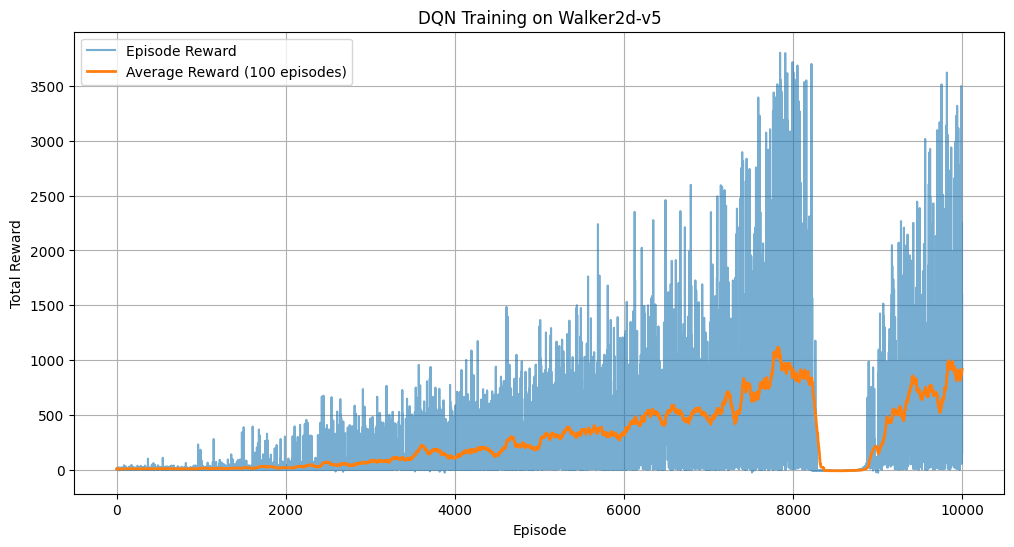

In [32]:

# plt.plot(loss_dict.keys(), loss_dict.values())
# plt.plot(rewards.keys(), rewards.values())

plt.figure(figsize=(12, 6))
plt.plot(all_rewards, label='Episode Reward', alpha=0.6)
plt.plot(avg_rewards, label='Average Reward (100 episodes)', linewidth=2)
plt.title('DQN Training on Walker2d-v5')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# import gymnasium as gym
# import torch
# import time
# import numpy as np

# # --- Assume your QNetwork and other necessary components are defined here ---
# # from your_model_file import QNetwork # Make sure to import your network architecture

# # --- Hyperparameters and Setup ---
# # Load the environment with rendering enabled
# env = gym.make('Walker2d-v4', render_mode='human') # <-- IMPORTANT

# # Initialize your Q-network and load the trained weights
# # Ensure the state_size and action_size match your environment
# state_size = env.observation_space.shape[0]
# # action_size = env.action_space.n
# q_network = DQN(128, state_size, action_size) # Your network class
# q_network.load_state_dict(torch.load('q_network_weights_walker.pth'))
# q_network.eval() # Set the network to evaluation mode

# # --- The Greedy Action Function ---
# def greedy_action(state):
#     """Chooses the best action based on the Q-network's prediction."""
#     with torch.no_grad():
#         state_tensor = torch.FloatTensor(state).unsqueeze(0)
#         q_values = q_network(state_tensor)
#         return np.argmax(q_values.cpu().data.numpy())

# # --- The Visual Testing Loop ---
# num_test_episodes = 1000

# for episode in range(num_test_episodes):
#     reset_result = env.reset()
#     state = reset_result[0] if isinstance(reset_result, tuple) else reset_result
#     total_reward = 0
#     terminated = False
#     truncated = False

#     while not (terminated or truncated):
#         # Render the environment
#         env.render()

#         # Agent chooses the best action (no epsilon)
#         action_index = epsilon_greedy_action(state=state)

#         # Environment takes a step
#         action = discrete_actions[action_index]
#         step_result = env.step(action)

#         # Unpack the step result
#         if len(step_result) == 5:
#             next_state, reward, terminated, truncated, _ = step_result
#         else: # For older gym versions
#             next_state, reward, done, _ = step_result
#             terminated = done
#             truncated = done # Simplification for older API

#         state = next_state
#         total_reward += reward

#         # Optional: Add a small delay to make the visualization easier to follow
#         time.sleep(0.02)

#     print(f"Test Episode {episode + 1}, Total Reward: {total_reward}")

# env.close()

# Gemini Code

In [22]:
# import gymnasium as gym
# import random
# import numpy as np
# from collections import deque
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from tqdm import tqdm
# import time

# # --- 1. Define the Discretized Action Space ---
# # The Walker2d-v4 environment has a continuous action space of shape (6,).
# # We will discretize this space into a set of specific actions.
# # Action 0: No action
# # Actions 1-6: Positive torque to one joint
# # Actions 7-12: Negative torque to one joint
# num_joints = 6
# base_actions = np.eye(num_joints)  # Identity matrix for single joint activation
# # Create a list of 13 actions: no-op, positive torque on each joint, negative torque on each joint
# discrete_actions = (
#     [[0.0] * num_joints] +  # No action
#     base_actions.tolist() +
#     (-base_actions).tolist()
# )
# action_size = len(discrete_actions)


# # --- 2. Neural Network Definition (DQN) ---
# class DQN(nn.Module):
#     """Deep Q-Network model."""
#     def __init__(self, hidden_units, state_size, action_size):
#         super(DQN, self).__init__()
#         self.hidden_units = hidden_units
#         self.input_dim = state_size
#         self.output_dim = action_size

#         # The network architecture
#         self.q_network = nn.Sequential(
#             nn.Linear(self.input_dim, hidden_units),
#             nn.ReLU(),
#             nn.Linear(hidden_units, hidden_units),
#             nn.ReLU(),
#             nn.Linear(hidden_units, self.output_dim)
#         )
    
#     def forward(self, x):
#         """Forward pass through the network."""
#         # The input x might be a numpy array, so we convert it to a tensor.
#         if not isinstance(x, torch.Tensor):
#             x = torch.tensor(x, dtype=torch.float32)
#         return self.q_network(x)


# # --- 3. Environment and Hyperparameter Setup ---
# # Initialize the environment
# env = gym.make('Walker2d-v4')
# state_size = env.observation_space.shape[0]

# # Hyperparameters
# gamma = 0.99           # Discount factor
# epsilon = 1.0          # Initial exploration rate
# epsilon_min = 0.01     # Minimum exploration rate
# epsilon_decay = 0.995  # Decay rate for exploration
# learning_rate = 0.001
# batch_size = 64
# memory_size = 10000
# hidden_units_dqn = 256 # Increased hidden units for a more complex task
# episodes = 500         # Total episodes for training
# target_update_freq = 10 # How often to update the target network

# # Replay memory
# memory = deque(maxlen=memory_size)

# # --- 4. Initialize Networks and Optimizer ---
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print(f"Using device: {device}")
# print(f"State size: {state_size}")
# print(f"Discretized action size: {action_size}")


# q_network = DQN(hidden_units_dqn, state_size=state_size, action_size=action_size).to(device)
# target_network = DQN(hidden_units_dqn, state_size=state_size, action_size=action_size).to(device)
# target_network.load_state_dict(q_network.state_dict())
# target_network.eval()  # Set target network to evaluation mode

# optimizer = optim.Adam(q_network.parameters(), lr=learning_rate)
# loss_fn = nn.MSELoss()


# # --- 5. Action Selection and Replay Functions ---
# def epsilon_greedy_action(state, epsilon_val):
#     """
#     Selects an action using an epsilon-greedy policy.
#     Returns an index from the discrete_actions list.
#     """
#     if random.random() < epsilon_val:
#         return random.choice(range(action_size))  # Return a random action index
#     else:
#         state = torch.FloatTensor(state).unsqueeze(0).to(device)
#         with torch.no_grad():
#             q_values = q_network(state)
#         return q_values.argmax().item() # Return the index of the best action

# def replay():
#     """
#     Trains the Q-network using a batch of experiences from the replay memory.
#     """
#     if len(memory) < batch_size:
#         return 
    
#     minibatch = random.sample(memory, batch_size)
    
#     current_states, actions, rewards, next_states, dones = zip(*minibatch)

#     current_states = torch.FloatTensor(np.array(current_states)).to(device)
#     # actions are indices, need to be LongTensor for gather
#     actions = torch.LongTensor(actions).unsqueeze(1).to(device)
#     rewards = torch.FloatTensor(rewards).unsqueeze(1).to(device)
#     next_states = torch.FloatTensor(np.array(next_states)).to(device)
#     dones = torch.FloatTensor(dones).unsqueeze(1).to(device)

#     # Get Q-values for current states from the main network
#     current_q = q_network(current_states).gather(1, actions)
    
#     # Get max Q-values for next states from the target network
#     next_q_values = target_network(next_states).max(1)[0].detach().unsqueeze(1)
    
#     # Compute the target Q-value
#     target_q = rewards + (gamma * next_q_values * (1 - dones))
    
#     # Compute loss and update the network
#     loss = loss_fn(current_q, target_q)
#     optimizer.zero_grad()
#     loss.backward()
#     # Gradient clipping to prevent exploding gradients
#     torch.nn.utils.clip_grad_norm_(q_network.parameters(), 1.0)
#     optimizer.step()


# # --- 6. Training Loop ---
# print("\n--- Starting Training ---")
# all_rewards = []
# for episode in tqdm(range(episodes)):
#     # Reset environment and get initial state
#     state, info = env.reset()
#     total_reward = 0
#     done = False
    
#     while not done:
#         # Select action index using epsilon-greedy policy
#         action_index = epsilon_greedy_action(state, epsilon)
#         # Get the continuous action vector from the discrete list
#         continuous_action = discrete_actions[action_index]
        
#         # Take a step in the environment
#         next_state, reward, terminated, truncated, _ = env.step(continuous_action)
#         done = terminated or truncated

#         # Store experience in replay memory
#         memory.append((state, action_index, reward, next_state, done))
        
#         state = next_state
#         total_reward += reward

#         # Train the network by replaying experiences
#         replay()

#     # Decay epsilon
#     if epsilon > epsilon_min:
#         epsilon *= epsilon_decay

#     # Update target network
#     if episode % target_update_freq == 0:
#         target_network.load_state_dict(q_network.state_dict())

#     all_rewards.append(total_reward)
    
#     if episode % 50 == 0:
#         avg_reward = np.mean(all_rewards[-50:]) if all_rewards else 0
#         print(f"Episode {episode}, Total Reward: {total_reward:.2f}, Avg Reward (last 50): {avg_reward:.2f}, Epsilon: {epsilon:.3f}")

# print("\n--- Training Finished ---")

# # --- 7. Save the Trained Model ---
# model_path = 'walker2d_dqn_weights.pth'
# torch.save(q_network.state_dict(), model_path)
# print(f"Model saved to {model_path}")


## Visualization Code 

In [34]:
import time

# --- 8. Visual Testing Loop ---
print("\n--- Starting Visual Test ---")

# Load the trained model
# test_q_network = DQN(hidden_units_dqn, state_size, action_size).to(device)
# test_q_network.load_state_dict(torch.load(model_path))
# test_q_network.eval()

test_q_network = DQN(256, state_size, action_size) # Your network class
test_q_network.load_state_dict(torch.load('walker_weights/q_network_weights_walker.pth'))
test_q_network.to(device)
test_q_network.eval() # Set the network to evaluation mode



# Create a new environment with render_mode='human'
test_env = gym.make('Walker2d-v5', render_mode='human')

def greedy_action_test(state):
    """Chooses the best action based on the Q-network's prediction (no exploration)."""
    with torch.no_grad():
        state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
        q_values = test_q_network(state_tensor)
        return q_values.argmax().item()

num_test_episodes = 10
for episode in range(num_test_episodes):
    state, info = test_env.reset()
    total_reward = 0
    done = False

    while not done:
        # Render the environment
        test_env.render()
        
        # Agent chooses the best action (no epsilon)
        action_index = greedy_action_test(state)
        continuous_action = discrete_actions[action_index]
        
        # Environment takes a step
        next_state, reward, terminated, truncated, _ = test_env.step(continuous_action)
        done = terminated or truncated
        
        state = next_state
        total_reward += reward
        
        # Add a small delay to make visualization easier
        time.sleep(0.02)

    print(f"Test Episode {episode + 1}, Total Reward: {total_reward:.2f}")

test_env.close()




--- Starting Visual Test ---
Test Episode 1, Total Reward: 374.43
Test Episode 2, Total Reward: 686.33
Test Episode 3, Total Reward: 547.06
Test Episode 4, Total Reward: 1363.08
Test Episode 5, Total Reward: 377.83
Test Episode 6, Total Reward: 167.07
Test Episode 7, Total Reward: 1046.23
Test Episode 8, Total Reward: 104.16
Test Episode 9, Total Reward: 97.73
Test Episode 10, Total Reward: 882.24
